# Final Project Code: Linear Models in Python
# Jacob Tiede

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import KFold

#-----------
#Read in the data and preprocess
#-----------
data = pd.read_csv('./Data/train_features.csv')
data = data.drop(['sig_id'], axis=1)

#Some columns are coded with strings, need them to be numeric
label_enc = LabelEncoder()
data['cp_type'] = label_enc.fit_transform(data.cp_type.values)
data['cp_time'] = label_enc.fit_transform(data.cp_time.values)
data['cp_dose'] = label_enc.fit_transform(data.cp_dose.values)

#convert to numpy:
col_names_data = list(data.columns) #keep a list of column names for later
data = data.to_numpy()

#Column-wise normalization usually helps with these problems:
transformer = Normalizer().fit(data)
data = transformer.transform(data)
#add the bias column: NOT REQUIRED, but it helps with some of the logic of the program (this could be done in pytorch automatically, by allowing the linear layer to have a bias)
data = np.append(np.ones(data.shape[0]).reshape(-1,1), data, 1)

#load in the response:
response = pd.read_csv('./Data/train_targets_scored.csv')
response = response.drop(['sig_id'], axis=1) #Drop ID since it cannot have a meaningful impact on explanation
col_names_response = list(response.columns) #save a list of response column names just in case
response = response.to_numpy()

#Find k folds for k-fold cross validation:
kf = KFold(n_splits=10, random_state = 0, shuffle = True)
kf.get_n_splits(data)
kcross = kf.split(data, response) #creates an iteratable that we will use later

In [2]:
#create the neural net class NOTE: this assumes you have a working GPU and have installed pytorch with gpu libraries
"""
log_reg -- a class that stores the parameters of a multivariate multiple logistic regress
Note: This class uses a sigmoid link function instead of a logit link function

@params: --input_features: int, the number of features which the model will use as predictors
         --output_features: int, the number of expected outputs, this is the number of logistic regression models to be trained simultaniously
"""
class log_reg(nn.Module):
    def __init__(self, input_features, output_features):
        super(log_reg, self).__init__()
        self.fc_layer = nn.Linear(input_features, output_features, bias = False)
    def forward(self, x):
        x = F.sigmoid(self.fc_layer(x))
        return x
torch.manual_seed(35) #set seed for reproducability

In [11]:
import progressbar #This is the progressbar2 library if it must be installed

fold = 1 #keeps track of which fold we are on

#do training loop for each fold in the K-fold cross:
for train_index, test_index in kcross:
    X_train, X_test = data[train_index], data[test_index]
    y_train, y_test = response[train_index], response[test_index]
    
    #Initialize necessary constants like batch size, etc as well as the model:
    model = log_reg(data.shape[1], response.shape[1]).cuda() #again requires a working gpu
    opt = torch.optim.Adam(model.parameters()) #Initializes and tells the optimizer what parameters to keep track of
    batch_size = 64 #This could probably be increased, but 64 seems to work well enough
    epochs = 30
    loss = nn.BCELoss() #Binary cross entropy loss, the loss function defined in the write up
    batchesPerEpoch = int(np.floor(X_train.shape[0]/batch_size))
    
    #-----------
    #training loop
    #-----------
    with progressbar.ProgressBar(max_value=epochs*batchesPerEpoch) as bar:
        for epoch in range(epochs):
            for i in range(batchesPerEpoch):
                opt.zero_grad()
                batch_x = torch.from_numpy(X_train[i*batch_size:(i+1)*batch_size,:]).float().cuda()
                batch_y = torch.from_numpy(y_train[i*batch_size:(i+1)*batch_size,:]).cuda()
                #forward pass:
                out = model(batch_x)
                batch_loss = torch.mean(loss(out, batch_y.float()))
                batch_loss.backward()
                opt.step()
                bar.update(i+batchesPerEpoch*epoch)
    #-----------            
    #Get train stats:
    #-----------
    accuracy = []
    test_loss = []
    model.eval()
    with torch.no_grad():
        for i in range(batchesPerEpoch):
            batch_x = torch.from_numpy(X_train[i*batch_size:(i+1)*batch_size,:]).float().cuda()
            batch_y = torch.from_numpy(y_train[i*batch_size:(i+1)*batch_size,:]).cuda()
            out = model(batch_x)
            test_loss.append(torch.mean(loss(out, batch_y.float())).item()) 
            accuracy.append(torch.sum(torch.round(out) == batch_y).item()/(out.shape[0]*out.shape[1]))
    print("The train statistics for fold " + str(fold) + " were:")
    print("accuracy: " + str(np.mean(accuracy)))
    print("loss: " + str(np.mean(test_loss)))    
    
    #-----------
    #Get test stats:
    #-----------
    accuracy = []
    test_loss = []
    batches = int(np.floor(X_test.shape[0]/batch_size))
    with torch.no_grad():
        for i in range(batches):
            batch_x = torch.from_numpy(X_test[i*batch_size:(i+1)*batch_size,:]).float().cuda()
            batch_y = torch.from_numpy(y_test[i*batch_size:(i+1)*batch_size,:]).cuda()
            out = model(batch_x)
            test_loss.append(torch.mean(loss(out, batch_y.float())).item()) 
            accuracy.append(torch.sum(torch.round(out) == batch_y).item()/(out.shape[0]*out.shape[1]))
    print("The train statistics for fold " + str(fold) + " were:")
    print("accuracy: " + str(np.mean(accuracy)))
    print("loss: " + str(np.mean(test_loss)))  
    fold += 1
    
    

C:\Users\JAT\anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100% (10020 of 10020) |##################| Elapsed Time: 0:00:09 Time:  0:00:09
  1% (103 of 10020) |                    | Elapsed Time: 0:00:00 ETA:   0:00:09

The train statistics for fold 1 were:
accuracy: 0.9971635915063078
loss: 0.015549170781863842
The train statistics for fold 1 were:
accuracy: 0.9970685187614802
loss: 0.01800676988991531


100% (10020 of 10020) |##################| Elapsed Time: 0:00:09 Time:  0:00:09
N/A% (0 of 10020) |                      | Elapsed Time: 0:00:00 ETA:  --:--:--

The train statistics for fold 2 were:
accuracy: 0.9971545077321087
loss: 0.015628117741738074
The train statistics for fold 2 were:
accuracy: 0.9971956179480451
loss: 0.017190761436280365


100% (10020 of 10020) |##################| Elapsed Time: 0:00:09 Time:  0:00:09
  1% (109 of 10020) |                    | Elapsed Time: 0:00:00 ETA:   0:00:09

The train statistics for fold 3 were:
accuracy: 0.9971685875821173
loss: 0.015561347609820838
The train statistics for fold 3 were:
accuracy: 0.9970644187877198
loss: 0.017855714629026683


100% (10020 of 10020) |##################| Elapsed Time: 0:00:09 Time:  0:00:09
  1% (104 of 10020) |                    | Elapsed Time: 0:00:00 ETA:   0:00:09

The train statistics for fold 4 were:
accuracy: 0.9971617747514677
loss: 0.01554152829583712
The train statistics for fold 4 were:
accuracy: 0.9971320683547625
loss: 0.018008565681206214


100% (10020 of 10020) |##################| Elapsed Time: 0:00:09 Time:  0:00:09
N/A% (0 of 10020) |                      | Elapsed Time: 0:00:00 ETA:  --:--:--

The train statistics for fold 5 were:
accuracy: 0.9971590496192082
loss: 0.015583967087333074
The train statistics for fold 5 were:
accuracy: 0.9971689681186041
loss: 0.017476386541651713


100% (10020 of 10020) |##################| Elapsed Time: 0:00:09 Time:  0:00:09
N/A% (0 of 10020) |                      | Elapsed Time: 0:00:00 ETA:  --:--:--

The train statistics for fold 6 were:
accuracy: 0.9971556432038834
loss: 0.015624830691690395
The train statistics for fold 6 were:
accuracy: 0.9972079178693257
loss: 0.017235161107335542


100% (10020 of 10020) |##################| Elapsed Time: 0:00:09 Time:  0:00:09
N/A% (0 of 10020) |                      | Elapsed Time: 0:00:00 ETA:  --:--:--

The train statistics for fold 7 were:
accuracy: 0.9971592767135632
loss: 0.015570653716804918
The train statistics for fold 7 were:
accuracy: 0.9971751180792442
loss: 0.01787060801241849


100% (10020 of 10020) |##################| Elapsed Time: 0:00:09 Time:  0:00:09
N/A% (0 of 10020) |                      | Elapsed Time: 0:00:00 ETA:  --:--:--

The train statistics for fold 8 were:
accuracy: 0.997171766903087
loss: 0.01553338622774728
The train statistics for fold 8 were:
accuracy: 0.9970377689582787
loss: 0.01818494118649412


100% (10020 of 10020) |##################| Elapsed Time: 0:00:09 Time:  0:00:09
N/A% (0 of 10020) |                      | Elapsed Time: 0:00:00 ETA:  --:--:--

The train statistics for fold 9 were:
accuracy: 0.997160412185338
loss: 0.015548926223247887
The train statistics for fold 9 were:
accuracy: 0.9970808186827606
loss: 0.01803042455198797


100% (10020 of 10020) |##################| Elapsed Time: 0:00:09 Time:  0:00:09


The train statistics for fold 10 were:
accuracy: 0.9971658624498577
loss: 0.015575567316152379
The train statistics for fold 10 were:
accuracy: 0.9970767187090002
loss: 0.017709220533032675


In [12]:
# To get p-values of the coefficients we need standard errors, to do this we will use bootstrapping:
n = 50 #number of bootstrapped samples to consider
m = int(data.shape[0]*99/100) #number of bootstrapped samples
boot_coeff = torch.zeros(206,876,n) #3D array of coefficients dimension each slice along dim 2 is a mxn matrix of parameters

#Also going to use this to test my chi-squared test for model sufficiency, for which we'll need to record some stuff:
boot_pred = np.zeros((m,response.shape[1], n))
boot_response = np.zeros((m,response.shape[1], n))
"""
generateBootSample -- generates a sample of rows from X and y with replacement

@params -- X a numpy array to sample 
        -- y a second numpy array to generate the same sample from
        -- size an int for the size of the bootstrapped sample
"""
def generateBootSample(X,y, size):
    samples = torch.randint(0, int(X.shape[0]), (size, 1)).view(-1).numpy()
    
    return X[samples, :], y[samples,:]

#-----------
#train a model for each bootstrapped sample required, store the parameters in boot_coeff for each one
#-----------
with progressbar.ProgressBar(max_value=n) as bar:
    for sample in range(n):
        X_train, y_train = generateBootSample(data, response, m)
        #Initialize necessary constants like batch size, etc as well as the model:
        model = log_reg(data.shape[1], response.shape[1]).cuda()
        opt = torch.optim.Adam(model.parameters())
        batch_size = 64
        epochs = 30
        loss = nn.BCELoss()
        batchesPerEpoch = int(np.floor(X_train.shape[0]/batch_size))

        for epoch in range(epochs):
            for i in range(batchesPerEpoch):
                opt.zero_grad()
                batch_x = torch.from_numpy(X_train[i*batch_size:(i+1)*batch_size,:]).float().cuda()
                batch_y = torch.from_numpy(y_train[i*batch_size:(i+1)*batch_size,:]).cuda()
                #forward pass:
                out = model(batch_x)
                batch_loss = torch.mean(loss(out, batch_y.float()))
                batch_loss.backward()
                opt.step()
        
        #-----------
        #Get stuff required to evaluate the chi-squared test later
        #-----------
        boot_response[:,:,sample] = y_train
        model.eval()
        with torch.no_grad():
            for i in range(batchesPerEpoch):
                batch_x = torch.from_numpy(X_train[i*batch_size:(i+1)*batch_size,:]).float().cuda()
                batch_y = torch.from_numpy(y_train[i*batch_size:(i+1)*batch_size,:]).cuda()
                out = model(batch_x)
                boot_pred[i*batch_size:(i+1)*batch_size,:, sample] = out.detach().cpu().numpy()
                
        bar.update(sample)
        for param in model.parameters():
            boot_coeff[:,:,sample] = param.detach().cpu()

100% (50 of 50) |########################| Elapsed Time: 0:09:06 Time:  0:09:06


In [13]:
standard_errors = torch.std(boot_coeff, dim = 2) #estimate the standard error of the coefficients using the bootstrapped sample

#-----------
#train a final model:
#-----------
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, response, test_size=0.1, random_state=0) #create a final split

#Initialize necessary constants like batch size, etc as well as the model:
model = log_reg(data.shape[1], response.shape[1]).cuda()
opt = torch.optim.Adam(model.parameters())
batch_size = 64
epochs = 30
loss = nn.BCELoss()
batchesPerEpoch = int(np.floor(X_train.shape[0]/batch_size))

#-----------
#training loop
#-----------
with progressbar.ProgressBar(max_value=epochs*batchesPerEpoch) as bar:
    for epoch in range(epochs):
        for i in range(batchesPerEpoch):
            opt.zero_grad()
            batch_x = torch.from_numpy(X_train[i*batch_size:(i+1)*batch_size,:]).float().cuda()
            batch_y = torch.from_numpy(y_train[i*batch_size:(i+1)*batch_size,:]).cuda()
            #forward pass:
            out = model(batch_x)
            batch_loss = torch.mean(loss(out, batch_y.float()))
            batch_loss.backward()
            opt.step()
            bar.update(i+batchesPerEpoch*epoch)

#-----------
#Get train stats:
#-----------
accuracy = []
test_loss = []
model.eval()
pred_probs = np.zeros(y_train.shape)
with torch.no_grad():
    for i in range(batchesPerEpoch):
        batch_x = torch.from_numpy(X_train[i*batch_size:(i+1)*batch_size,:]).float().cuda()
        batch_y = torch.from_numpy(y_train[i*batch_size:(i+1)*batch_size,:]).cuda()
        out = model(batch_x)
        pred_probs[i*batch_size:(i+1)*batch_size,:] = out.cpu().numpy()
        test_loss.append(torch.mean(loss(out, batch_y.float())).item()) 
        accuracy.append(torch.sum(torch.round(out) == batch_y).item()/(out.shape[0]*out.shape[1]))
print("The train statistics for the full model:")
print("accuracy: " + str(np.mean(accuracy)))
print("loss: " + str(np.mean(test_loss)))  

#-----------
#Get test stats:
#-----------
accuracy = []
test_loss = []
batches = int(np.floor(X_test.shape[0]/batch_size))
pred_probs_test = np.zeros(y_test.shape)
with torch.no_grad():
    for i in range(batches):
        batch_x = torch.from_numpy(X_test[i*batch_size:(i+1)*batch_size,:]).float().cuda()
        batch_y = torch.from_numpy(y_test[i*batch_size:(i+1)*batch_size,:]).cuda()
        out = model(batch_x)
        pred_probs_test[i*batch_size:(i+1)*batch_size,:] = out.cpu().numpy()
        test_loss.append(torch.mean(loss(out, batch_y.float())).item()) 
        accuracy.append(torch.sum(torch.round(out) == batch_y).item()/(out.shape[0]*out.shape[1]))
print("The train statistics for the full model were:")
print("accuracy: " + str(np.mean(accuracy)))
print("loss: " + str(np.mean(test_loss)))  

#-----------
#get p-values for coefficients:
#-----------
#get z-scores of the paramters
for param in model.parameters():
    z_scores = torch.abs(torch.div(param.detach().cpu(), standard_errors)).numpy()

#get the p-values
from scipy.stats import norm
p_vals = 1 - norm.cdf(z_scores)

100% (10020 of 10020) |##################| Elapsed Time: 0:00:11 Time:  0:00:11


The train statistics for the full model:
accuracy: 0.9971699501482473
loss: 0.01553173159377393
The train statistics for the full model were:
accuracy: 0.9970726187352399
loss: 0.017991432441851578


In [14]:
print("The lowest p-value:")
print(np.min(p_vals))
print("The highest p-value:")
print(np.max(p_vals))
print("The proportion of parameters that are significant (across all models):")
print(np.sum(p_vals < .05)/(p_vals.shape[0]*p_vals.shape[1]))

count = 0
for i in range(p_vals.shape[1]):
    if np.sum(p_vals[:,i]<.05) == 0:
        count += 1
print("The number of predictors that are non-significant in all models:")
print(count)
count = 0
for i in range(p_vals.shape[1]):
    if np.sum(p_vals[:,i]<.05) <= 10:
        count += 1
print("The number of predictors that are non-significant in all but 10 or less models:")
print(count)

count = 0
for i in range(p_vals.shape[1]):
    if np.sum(p_vals[:,i]<.05) <= 50:
        count += 1
print("The number of predictors that are non-significant in all but 50 or less models:")
print(count)

The lowest p-value:
0.0
The highest p-value:
0.499997732682243
The proportion of parameters that are significant (across all models):
0.6904009841734273
The number of predictors that are non-significant in all models:
0
The number of predictors that are non-significant in all but 10 or less models:
1
The number of predictors that are non-significant in all but 50 or less models:
108


In [15]:
#Lastly let's code a chi squared test for this:
#Inspiration for some of this code: 
#https://stackoverflow.com/questions/50975774/calculate-residual-deviance-from-scikit-learn-logistic-regression-model
from sklearn.metrics import log_loss
"""
resid_dev -- given predicted probabilities and actual realizations return the residual deviance

@params: --pred_probs - a numpy array of predicted probabiliities
         --y - a numpy array of actual classifications
"""
def resid_dev(pred_probs, y):
    out = np.zeros(y.shape[1])
    for i in range(y.shape[1]):
        out[i] = 2*log_loss(y[:,i], pred_probs[:,i], normalize=False, labels = [0,1])
    return out

deviances = resid_dev(pred_probs, y_train) #find the residual deviances of the model

#this is the residual deviance so we can construct chi squared tests for all of them (to see if the current model is sufficient)
dof = response.shape[0] - data.shape[1] #degrees of freedom

#-----------
#Do the chi-squared test for model sufficiency
#-----------
from scipy.stats import chi2
test_pvals = 1-chi2.cdf(deviances, dof)
print("Number of insufficient models: " + str(np.sum(test_pvals<.05)))

Number of insufficient models: 0


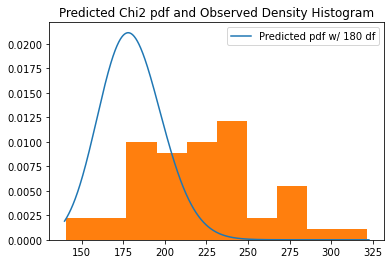

In [16]:
import matplotlib.pyplot as plt
#-----------
#A way to check this test is to see if a chi squared distribution does look like the density given by the bootstrapped samples from above:
#-----------
devs = []
for i in range(boot_pred.shape[2]):
    devs.append(resid_dev(boot_pred[:,1,i].reshape(-1,1), boot_response[:,1,i].reshape(-1,1))[0])

x = np.linspace(np.min(devs)-1, np.max(devs)+1, 1000)
plt.plot(x, chi2.pdf(x, 180), label='Predicted pdf w/ 180 df')
plt.hist(devs, density = True)
plt.legend(loc = 'best')
plt.title("Predicted Chi2 pdf and Observed Density Histogram")
plt.show()

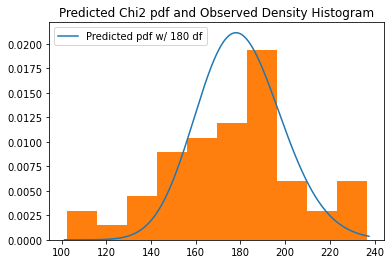

In [17]:
devs = []
for i in range(boot_pred.shape[2]):
    devs.append(resid_dev(boot_pred[:,0,i].reshape(-1,1), boot_response[:,0,i].reshape(-1,1))[0])

x = np.linspace(np.min(devs)-1, np.max(devs)+1, 1000)
plt.plot(x, chi2.pdf(x, 180), label='Predicted pdf w/ 180 df')
plt.hist(devs, density = True)
plt.legend(loc = 'best')
plt.title("Predicted Chi2 pdf and Observed Density Histogram")
plt.show()

In [18]:
#A quick sanity check that giving random data will produce only insufficient models:
deviances2 = resid_dev(np.random.rand(response.shape[0],response.shape[1]), response)

#this is the residual deviance so we can construct chi squared tests for all of them (to see if the current model is sufficient)
dof = response.shape[0] - data.shape[1]

from scipy.stats import chi2
test_pvals = 1-chi2.cdf(deviances2, dof)
print("Number of insufficient models: " + str(np.sum(test_pvals<.05)))

Number of insufficient models: 206


In [19]:
#-----------
#Look at an aggregated confusion matrix of the models (take average values for the matrices)
#-----------
from sklearn.metrics import confusion_matrix
conf_matrix = np.zeros((2,2,pred_probs.shape[1]))
for i in range(pred_probs.shape[1]):
    conf_matrix[:,:,i] = confusion_matrix(y_train[:,i], np.round(pred_probs[:,i]))
print("The confusion matrix for this model on the train set is:")
print(np.mean(conf_matrix, axis = 2))

conf_matrix = np.zeros((2,2,pred_probs_test.shape[1]))
for i in range(pred_probs_test.shape[1]):
    conf_matrix[:,:,i] = confusion_matrix(y_test[:,i], np.round(pred_probs_test[:,i]))
print("The confusion matrix for this model on the test set is:")
print(np.mean(conf_matrix, axis = 2))

The confusion matrix for this model on the train set is:
[[21357.57281553   104.95145631]
 [  163.83980583   117.75242718]]
The confusion matrix for this model on the test set is:
[[2373.64563107  196.67475728]
 [ 203.44660194  197.95145631]]


# Dimensionality Reduction Via VIF
Results indicate that any split of the data is sufficient and will yeild simular training. Now look at VIF:

In [9]:
from sklearn.linear_model import LinearRegression
"""
VIF -- find the variance inflation factor for each column of a given matrix

@params: --X: a numpy array which we will find VIFs for
"""
def VIF(X):
    vifs = []
    with progressbar.ProgressBar(max_value=int(X.shape[1])) as bar:
        for i in range(X.shape[1]):
            #Create an array which excludes the ith column
            relCols = [j for j in range(X.shape[1]) if j != i] 
            x = X[:, relCols]
            
            #fit a linear model onto the excluded column
            reg = LinearRegression().fit(x, X[:,i])
            vifs.append(1/(1-reg.score(x, X[:,i])))
            bar.update(i)
    return vifs


vifs = VIF(X_train[:, 1:X_train.shape[0]]) #drop bias column for this calculation


100% (875 of 875) |######################| Elapsed Time: 0:12:30 Time:  0:12:30


In [10]:
print("The max VIF for the base model was " + str(max(vifs)))
print("The condition number of the base matrix is: " + str(np.linalg.cond(X_train[:,1:X_train.shape[1]])))

The max VIF for the base model was 8.269421633323343
The condition number of the base matrix is: 41.52752960126006


In [11]:
#eliminate the highest VIF and see what the condition number was, then repeat:

n = 100 #max number of columns to remove
col_to_elim = [] #a list of column names which are eliminated in this process
temp_data = X_train[:, 1:X_train.shape[0]] #Eliminate the bias column while we do this calculation
col_names_data_temp = col_names_data.copy()

#-----------
#Dimensionality reduction using the VIF
#Stopping criterian: if the condition number is less than 30 or if we have eliminated 100 columns (this is due to time constraints)
#-----------
for i in range(n):
    topInd = np.argsort(vifs)[-1] #find the index of the highest VIF
    col_to_elim.append(col_names_data_temp[topInd]) #record the name of the col to be eliminated
    
    #-----------
    #Eliminate highest VIF column from both the column names and the temp data
    #-----------
    col_names_data_temp.pop(topInd) 
    relCols = [j for j in range(temp_data.shape[1]) if j != topInd] 
    temp_data = temp_data[:, relCols]
    
    #find an state the condition number
    cond = np.linalg.cond(temp_data)
    print("The condition number of this iteration is: " + str(cond))
    
    #stopping condition
    if cond < 30:
        break
    #calculate new VIFs
    vifs = VIF(temp_data)
print(col_to_elim)

The condition number of this iteration is: 40.86190704387075


100% (874 of 874) |######################| Elapsed Time: 0:12:12 Time:  0:12:12


The condition number of this iteration is: 40.38941847312909


100% (873 of 873) |######################| Elapsed Time: 0:11:28 Time:  0:11:28


The condition number of this iteration is: 40.21960258021064


100% (872 of 872) |######################| Elapsed Time: 0:11:00 Time:  0:11:00


The condition number of this iteration is: 40.14979175921387


100% (871 of 871) |######################| Elapsed Time: 0:11:25 Time:  0:11:25


The condition number of this iteration is: 40.05845990783548


100% (870 of 870) |######################| Elapsed Time: 0:10:45 Time:  0:10:45


The condition number of this iteration is: 40.05594799971745


100% (869 of 869) |######################| Elapsed Time: 0:10:54 Time:  0:10:54


The condition number of this iteration is: 40.0444410025309


100% (868 of 868) |######################| Elapsed Time: 0:10:48 Time:  0:10:48


The condition number of this iteration is: 40.00297380345969


100% (867 of 867) |######################| Elapsed Time: 0:10:52 Time:  0:10:52


The condition number of this iteration is: 39.97294259689092


100% (866 of 866) |######################| Elapsed Time: 0:10:48 Time:  0:10:48


The condition number of this iteration is: 39.908841039099755


100% (865 of 865) |######################| Elapsed Time: 0:10:47 Time:  0:10:47


The condition number of this iteration is: 39.89389454520559


100% (864 of 864) |######################| Elapsed Time: 0:10:51 Time:  0:10:51


The condition number of this iteration is: 39.67396218099479


100% (863 of 863) |######################| Elapsed Time: 0:10:51 Time:  0:10:51


The condition number of this iteration is: 39.581316225658


100% (862 of 862) |######################| Elapsed Time: 0:10:48 Time:  0:10:48


The condition number of this iteration is: 39.544635136354486


100% (861 of 861) |######################| Elapsed Time: 0:10:39 Time:  0:10:39


The condition number of this iteration is: 39.466460826740864


100% (860 of 860) |######################| Elapsed Time: 0:10:36 Time:  0:10:36


The condition number of this iteration is: 39.45079956018348


100% (859 of 859) |######################| Elapsed Time: 0:10:30 Time:  0:10:30


The condition number of this iteration is: 37.808918661018815


100% (858 of 858) |######################| Elapsed Time: 0:11:01 Time:  0:11:01


The condition number of this iteration is: 37.80349283672296


100% (857 of 857) |######################| Elapsed Time: 0:10:40 Time:  0:10:40


The condition number of this iteration is: 37.68915466769941


100% (856 of 856) |######################| Elapsed Time: 0:10:47 Time:  0:10:47


The condition number of this iteration is: 37.44954606196908


100% (855 of 855) |######################| Elapsed Time: 0:10:37 Time:  0:10:37


The condition number of this iteration is: 37.39867452052772


100% (854 of 854) |######################| Elapsed Time: 0:10:39 Time:  0:10:39


The condition number of this iteration is: 37.3960878026293


100% (853 of 853) |######################| Elapsed Time: 0:10:37 Time:  0:10:37


The condition number of this iteration is: 37.32014799340859


100% (852 of 852) |######################| Elapsed Time: 0:10:54 Time:  0:10:54


The condition number of this iteration is: 37.21154368549519


100% (851 of 851) |######################| Elapsed Time: 0:10:28 Time:  0:10:28


The condition number of this iteration is: 34.943413039218896


100% (850 of 850) |######################| Elapsed Time: 0:10:32 Time:  0:10:32


The condition number of this iteration is: 34.91771296668034


100% (849 of 849) |######################| Elapsed Time: 0:10:44 Time:  0:10:44


The condition number of this iteration is: 34.87552574448633


100% (848 of 848) |######################| Elapsed Time: 0:10:30 Time:  0:10:30


The condition number of this iteration is: 34.85580142937162


100% (847 of 847) |######################| Elapsed Time: 0:10:21 Time:  0:10:21


The condition number of this iteration is: 34.841538516154365


100% (846 of 846) |######################| Elapsed Time: 0:09:55 Time:  0:09:55


The condition number of this iteration is: 34.83177917131003


100% (845 of 845) |######################| Elapsed Time: 0:09:56 Time:  0:09:56


The condition number of this iteration is: 34.82201148370746


100% (844 of 844) |######################| Elapsed Time: 0:09:55 Time:  0:09:55


The condition number of this iteration is: 34.7820195375577


100% (843 of 843) |######################| Elapsed Time: 0:09:53 Time:  0:09:53


The condition number of this iteration is: 34.7459424377119


100% (842 of 842) |######################| Elapsed Time: 0:09:52 Time:  0:09:52


The condition number of this iteration is: 34.22708376583285


100% (841 of 841) |######################| Elapsed Time: 0:09:48 Time:  0:09:48


The condition number of this iteration is: 34.214851163712474


100% (840 of 840) |######################| Elapsed Time: 0:09:48 Time:  0:09:48


The condition number of this iteration is: 34.198268993021145


100% (839 of 839) |######################| Elapsed Time: 0:09:45 Time:  0:09:45


The condition number of this iteration is: 31.604936092780413


100% (838 of 838) |######################| Elapsed Time: 0:09:40 Time:  0:09:40


The condition number of this iteration is: 31.57925959616027


100% (837 of 837) |######################| Elapsed Time: 0:09:38 Time:  0:09:38


The condition number of this iteration is: 31.46114708658209


100% (836 of 836) |######################| Elapsed Time: 0:09:40 Time:  0:09:40


The condition number of this iteration is: 31.248830394099308


100% (835 of 835) |######################| Elapsed Time: 0:09:32 Time:  0:09:32


The condition number of this iteration is: 31.104170839960517


100% (834 of 834) |######################| Elapsed Time: 0:09:30 Time:  0:09:30


The condition number of this iteration is: 31.07533593715494


100% (833 of 833) |######################| Elapsed Time: 0:09:37 Time:  0:09:37


The condition number of this iteration is: 31.038386272269086


100% (832 of 832) |######################| Elapsed Time: 0:09:49 Time:  0:09:49


The condition number of this iteration is: 30.87911122139734


100% (831 of 831) |######################| Elapsed Time: 0:09:36 Time:  0:09:36


The condition number of this iteration is: 30.830366147029878


100% (830 of 830) |######################| Elapsed Time: 0:09:32 Time:  0:09:32


The condition number of this iteration is: 30.813922957338246


100% (829 of 829) |######################| Elapsed Time: 0:09:28 Time:  0:09:28


The condition number of this iteration is: 30.80222812661647


100% (828 of 828) |######################| Elapsed Time: 0:09:49 Time:  0:09:49


The condition number of this iteration is: 30.762265383874848


100% (827 of 827) |######################| Elapsed Time: 0:09:49 Time:  0:09:49


The condition number of this iteration is: 30.756112399905653


100% (826 of 826) |######################| Elapsed Time: 0:09:40 Time:  0:09:40


The condition number of this iteration is: 30.74732781732603


100% (825 of 825) |######################| Elapsed Time: 0:09:28 Time:  0:09:28


The condition number of this iteration is: 30.73320643442421


100% (824 of 824) |######################| Elapsed Time: 0:09:26 Time:  0:09:26


The condition number of this iteration is: 30.699152468562513


100% (823 of 823) |######################| Elapsed Time: 0:09:21 Time:  0:09:21


The condition number of this iteration is: 30.652380734534955


100% (822 of 822) |######################| Elapsed Time: 0:09:21 Time:  0:09:21


The condition number of this iteration is: 30.644152567214746


100% (821 of 821) |######################| Elapsed Time: 0:09:18 Time:  0:09:18


The condition number of this iteration is: 30.64235511009651


100% (820 of 820) |######################| Elapsed Time: 0:09:17 Time:  0:09:17


The condition number of this iteration is: 30.633506734998505


100% (819 of 819) |######################| Elapsed Time: 0:09:17 Time:  0:09:17


The condition number of this iteration is: 30.603331641683273


100% (818 of 818) |######################| Elapsed Time: 0:09:15 Time:  0:09:15


The condition number of this iteration is: 30.59648496332336


100% (817 of 817) |######################| Elapsed Time: 0:09:11 Time:  0:09:11


The condition number of this iteration is: 30.55164412814701


100% (816 of 816) |######################| Elapsed Time: 0:09:12 Time:  0:09:12


The condition number of this iteration is: 30.54494680371747


100% (815 of 815) |######################| Elapsed Time: 0:09:09 Time:  0:09:09


The condition number of this iteration is: 30.385216262276312


100% (814 of 814) |######################| Elapsed Time: 0:09:06 Time:  0:09:06


The condition number of this iteration is: 30.380242428712414


100% (813 of 813) |######################| Elapsed Time: 0:09:04 Time:  0:09:04


The condition number of this iteration is: 30.364088327821364


100% (812 of 812) |######################| Elapsed Time: 0:09:03 Time:  0:09:03


The condition number of this iteration is: 30.349574091635525


100% (811 of 811) |######################| Elapsed Time: 0:09:02 Time:  0:09:02


The condition number of this iteration is: 30.315323537934816


100% (810 of 810) |######################| Elapsed Time: 0:09:00 Time:  0:09:00


The condition number of this iteration is: 30.314340834770896


100% (809 of 809) |######################| Elapsed Time: 0:08:58 Time:  0:08:58


The condition number of this iteration is: 30.258727625329506


100% (808 of 808) |######################| Elapsed Time: 0:09:01 Time:  0:09:01


The condition number of this iteration is: 30.253485303337282


100% (807 of 807) |######################| Elapsed Time: 0:08:56 Time:  0:08:56


The condition number of this iteration is: 30.24661439522932


100% (806 of 806) |######################| Elapsed Time: 0:08:56 Time:  0:08:56


The condition number of this iteration is: 29.351846752477485
['c-83', 'c-13', 'g-50', 'g-100', 'g-75', 'g-441', 'g-651', 'g-369', 'g-64', 'g-534', 'g-300', 'c-18', 'g-392', 'g-635', 'g-629', 'g-253', 'c-52', 'g-502', 'g-37', 'c-73', 'g-195', 'cp_dose', 'g-121', 'g-744', 'c-26', 'g-80', 'g-410', 'g-498', 'g-139', 'g-206', 'g-727', 'g-102', 'g-615', 'c-42', 'g-385', 'g-770', 'c-94', 'g-664', 'g-38', 'c-55', 'c-10', 'g-351', 'g-314', 'c-6', 'g-327', 'g-178', 'g-140', 'g-761', 'g-566', 'g-553', 'g-287', 'g-406', 'g-374', 'g-235', 'g-175', 'g-76', 'g-439', 'g-588', 'g-63', 'g-172', 'c-63', 'g-404', 'g-248', 'g-509', 'g-196', 'g-454', 'g-503', 'g-522', 'g-21', 'c-38']


In [20]:
col_to_elim = ['c-83', 'c-13', 'g-50', 'g-100', 'g-75', 'g-441', 'g-651', 'g-369', 'g-64', 'g-534', 'g-300', 'c-18', 
                'g-392', 'g-635', 'g-629', 'g-253', 'c-52', 'g-502', 'g-37', 'c-73', 'g-195', 'cp_dose', 'g-121', 'g-744', 
                'c-26', 'g-80', 'g-410', 'g-498', 'g-139', 'g-206', 'g-727', 'g-102', 'g-615', 'c-42', 'g-385', 'g-770', 'c-94', 
                'g-664', 'g-38', 'c-55', 'c-10', 'g-351', 'g-314', 'c-6', 'g-327', 'g-178', 'g-140', 'g-761', 'g-566', 'g-553', 'g-287', 'g-406', 'g-374', 
                'g-235', 'g-175', 'g-76', 'g-439', 'g-588', 'g-63', 'g-172', 'c-63', 'g-404', 'g-248', 'g-509', 'g-196', 'g-454', 'g-503', 'g-522', 'g-21', 'c-38']
print("Number of columns eliminated to acheive a condition number less than 30:")
print(len(col_to_elim))

Number of columns eliminated to acheive a condition number less than 30:
70


In [21]:
#since I don't want to have to rerun the code above I will have to create another data set:
ind_to_keep_bool = np.ones(data.shape[1], dtype = bool)
for i in range(data.shape[1]):
    if i != 0:
        if col_names_data[i-1] in col_to_elim:
            ind_to_keep_bool[i] = 0

red_data = data[:, ind_to_keep_bool]

#Find k folds for k-fold cross validation:
kf = KFold(n_splits=10, random_state = 0, shuffle = True)
kf.get_n_splits(red_data)
kcross = kf.split(red_data, response) #creates an iteratable that we will use later

fold = 1 #keeps track of which fold we are on

#do training loop for each fold in the K-fold cross:
for train_index, test_index in kcross:
    X_train, X_test = red_data[train_index], red_data[test_index]
    y_train, y_test = response[train_index], response[test_index]
    
    #Initialize necessary constants like batch size, etc as well as the model:
    model = log_reg(red_data.shape[1], response.shape[1]).cuda() #again requires a working gpu
    opt = torch.optim.Adam(model.parameters()) #Initializes and tells the optimizer what parameters to keep track of
    batch_size = 64 #This could probably be increased, but 64 seems to work well enough
    epochs = 30
    loss = nn.BCELoss() #Binary cross entropy loss, the loss function defined in the write up
    batchesPerEpoch = int(np.floor(X_train.shape[0]/batch_size))
    
    #-----------
    #training loop
    #-----------
    with progressbar.ProgressBar(max_value=epochs*batchesPerEpoch) as bar:
        for epoch in range(epochs):
            for i in range(batchesPerEpoch):
                opt.zero_grad()
                batch_x = torch.from_numpy(X_train[i*batch_size:(i+1)*batch_size,:]).float().cuda()
                batch_y = torch.from_numpy(y_train[i*batch_size:(i+1)*batch_size,:]).cuda()
                #forward pass:
                out = model(batch_x)
                batch_loss = torch.mean(loss(out, batch_y.float()))
                batch_loss.backward()
                opt.step()
                bar.update(i+batchesPerEpoch*epoch)
    #-----------            
    #Get train stats:
    #-----------
    accuracy = []
    test_loss = []
    model.eval()
    with torch.no_grad():
        for i in range(batchesPerEpoch):
            batch_x = torch.from_numpy(X_train[i*batch_size:(i+1)*batch_size,:]).float().cuda()
            batch_y = torch.from_numpy(y_train[i*batch_size:(i+1)*batch_size,:]).cuda()
            out = model(batch_x)
            test_loss.append(torch.mean(loss(out, batch_y.float())).item()) 
            accuracy.append(torch.sum(torch.round(out) == batch_y).item()/(out.shape[0]*out.shape[1]))
    print("The train statistics for fold " + str(fold) + " were:")
    print("accuracy: " + str(np.mean(accuracy)))
    print("loss: " + str(np.mean(test_loss)))    
    
    #-----------
    #Get test stats:
    #-----------
    accuracy = []
    test_loss = []
    batches = int(np.floor(X_test.shape[0]/batch_size))
    with torch.no_grad():
        for i in range(batches):
            batch_x = torch.from_numpy(X_test[i*batch_size:(i+1)*batch_size,:]).float().cuda()
            batch_y = torch.from_numpy(y_test[i*batch_size:(i+1)*batch_size,:]).cuda()
            out = model(batch_x)
            test_loss.append(torch.mean(loss(out, batch_y.float())).item()) 
            accuracy.append(torch.sum(torch.round(out) == batch_y).item()/(out.shape[0]*out.shape[1]))
    print("The train statistics for fold " + str(fold) + " were:")
    print("accuracy: " + str(np.mean(accuracy)))
    print("loss: " + str(np.mean(test_loss)))  
    fold += 1

C:\Users\JAT\anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100% (10020 of 10020) |##################| Elapsed Time: 0:00:08 Time:  0:00:08
N/A% (0 of 10020) |                      | Elapsed Time: 0:00:00 ETA:  --:--:--

The train statistics for fold 1 were:
accuracy: 0.9971476949014593
loss: 0.015840276557126803
The train statistics for fold 1 were:
accuracy: 0.9970562188401996
loss: 0.018172875978052616


100% (10020 of 10020) |##################| Elapsed Time: 0:00:08 Time:  0:00:08
  1% (118 of 10020) |                    | Elapsed Time: 0:00:00 ETA:   0:00:08

The train statistics for fold 2 were:
accuracy: 0.9971352047119352
loss: 0.01592043881209757
The train statistics for fold 2 were:
accuracy: 0.9971853680136444
loss: 0.017392672220798763


100% (10020 of 10020) |##################| Elapsed Time: 0:00:08 Time:  0:00:08
  1% (113 of 10020) |                    | Elapsed Time: 0:00:00 ETA:   0:00:08

The train statistics for fold 3 were:
accuracy: 0.9971486032788792
loss: 0.015854994797086467
The train statistics for fold 3 were:
accuracy: 0.9970582688270797
loss: 0.018030608903515984


100% (10020 of 10020) |##################| Elapsed Time: 0:00:08 Time:  0:00:08
N/A% (0 of 10020) |                      | Elapsed Time: 0:00:00 ETA:  --:--:--

The train statistics for fold 4 were:
accuracy: 0.9971436072030696
loss: 0.01583442405078136
The train statistics for fold 4 were:
accuracy: 0.997115668459722
loss: 0.018159668187837343


100% (10020 of 10020) |##################| Elapsed Time: 0:00:08 Time:  0:00:08
  1% (111 of 10020) |                    | Elapsed Time: 0:00:00 ETA:   0:00:08

The train statistics for fold 5 were:
accuracy: 0.9971411091651649
loss: 0.01587850388842161
The train statistics for fold 5 were:
accuracy: 0.9971546182104436
loss: 0.017614141408656095


100% (10020 of 10020) |##################| Elapsed Time: 0:00:09 Time:  0:00:09
N/A% (0 of 10020) |                      | Elapsed Time: 0:00:00 ETA:  --:--:--

The train statistics for fold 6 were:
accuracy: 0.9971352047119354
loss: 0.01591739144655848
The train statistics for fold 6 were:
accuracy: 0.997193567961165
loss: 0.0174160413695751


100% (10020 of 10020) |##################| Elapsed Time: 0:00:09 Time:  0:00:09
N/A% (0 of 10020) |                      | Elapsed Time: 0:00:00 ETA:  --:--:--

The train statistics for fold 7 were:
accuracy: 0.9971406549764549
loss: 0.015856526872912745
The train statistics for fold 7 were:
accuracy: 0.9971628181579638
loss: 0.018024778622831847


100% (10020 of 10020) |##################| Elapsed Time: 0:00:10 Time:  0:00:10
N/A% (0 of 10020) |                      | Elapsed Time: 0:00:00 ETA:  --:--:--

The train statistics for fold 8 were:
accuracy: 0.9971554161095285
loss: 0.015824282645041536
The train statistics for fold 8 were:
accuracy: 0.997023419050118
loss: 0.01835083991691873


100% (10020 of 10020) |##################| Elapsed Time: 0:00:10 Time:  0:00:10
N/A% (0 of 10020) |                      | Elapsed Time: 0:00:00 ETA:  --:--:--

The train statistics for fold 9 were:
accuracy: 0.9971420175425847
loss: 0.01584605443776546
The train statistics for fold 9 were:
accuracy: 0.9970767187090002
loss: 0.018226616915214707


100% (10020 of 10020) |##################| Elapsed Time: 0:00:09 Time:  0:00:09


The train statistics for fold 10 were:
accuracy: 0.9971495116562991
loss: 0.015865012983830567
The train statistics for fold 10 were:
accuracy: 0.9970644187877198
loss: 0.01789466938557657


In [22]:
# To get p-values of the coefficients we need standard errors, to do this we will use bootstrapping:
n = 50 #number of bootstrapped samples to consider
boot_coeff = torch.zeros(206,806,n) #3D array of coefficients dimension each slice along dim 2 is a mxn matrix of parameters
"""
generateBootSample -- generates a sample of rows from X and y with replacement

@params -- X a numpy array to sample 
        -- y a second numpy array to generate the same sample from
        -- size an int for the size of the bootstrapped sample
"""
def generateBootSample(X,y, size):
    samples = torch.randint(0, int(X.shape[0]), (size, 1)).view(-1).numpy()
    
    return X[samples, :], y[samples,:]

#-----------
#train a model for each bootstrapped sample required, store the parameters in boot_coeff for each one
#-----------
with progressbar.ProgressBar(max_value=n) as bar:
    for sample in range(n):
        X_train, y_train = generateBootSample(red_data, response, int(red_data.shape[0]*9/10))
        #Initialize necessary constants like batch size, etc as well as the model:
        model = log_reg(red_data.shape[1], response.shape[1]).cuda()
        opt = torch.optim.Adam(model.parameters())
        batch_size = 64
        epochs = 30
        loss = nn.BCELoss()
        batchesPerEpoch = int(np.floor(X_train.shape[0]/batch_size))

        for epoch in range(epochs):
            for i in range(batchesPerEpoch):
                opt.zero_grad()
                batch_x = torch.from_numpy(X_train[i*batch_size:(i+1)*batch_size,:]).float().cuda()
                batch_y = torch.from_numpy(y_train[i*batch_size:(i+1)*batch_size,:]).cuda()
                #forward pass:
                out = model(batch_x)
                batch_loss = torch.mean(loss(out, batch_y.float()))
                batch_loss.backward()
                opt.step()
                
        bar.update(sample)
        for param in model.parameters():
            boot_coeff[:,:,sample] = param.detach().cpu()
standard_errors = torch.std(boot_coeff, dim = 2) #estimate the standard error of the coefficients using the bootstrapped sample

#-----------
#train a final model:
#-----------
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(red_data, response, test_size=0.1, random_state=0) #create a final split

#Initialize necessary constants like batch size, etc as well as the model:
model = log_reg(red_data.shape[1], response.shape[1]).cuda()
opt = torch.optim.Adam(model.parameters())
batch_size = 64
epochs = 30
loss = nn.BCELoss()
batchesPerEpoch = int(np.floor(X_train.shape[0]/batch_size))

#-----------
#training loop
#-----------
with progressbar.ProgressBar(max_value=epochs*batchesPerEpoch) as bar:
    for epoch in range(epochs):
        for i in range(batchesPerEpoch):
            opt.zero_grad()
            batch_x = torch.from_numpy(X_train[i*batch_size:(i+1)*batch_size,:]).float().cuda()
            batch_y = torch.from_numpy(y_train[i*batch_size:(i+1)*batch_size,:]).cuda()
            #forward pass:
            out = model(batch_x)
            batch_loss = torch.mean(loss(out, batch_y.float()))
            batch_loss.backward()
            opt.step()
            bar.update(i+batchesPerEpoch*epoch)

#-----------
#Get train stats:
#-----------
accuracy = []
test_loss = []
model.eval()
pred_probs = np.zeros(y_train.shape)
with torch.no_grad():
    for i in range(batchesPerEpoch):
        batch_x = torch.from_numpy(X_train[i*batch_size:(i+1)*batch_size,:]).float().cuda()
        batch_y = torch.from_numpy(y_train[i*batch_size:(i+1)*batch_size,:]).cuda()
        out = model(batch_x)
        pred_probs[i*batch_size:(i+1)*batch_size,:] = out.cpu().numpy()
        test_loss.append(torch.mean(loss(out, batch_y.float())).item()) 
        accuracy.append(torch.sum(torch.round(out) == batch_y).item()/(out.shape[0]*out.shape[1]))
print("The train statistics for the full model:")
print("accuracy: " + str(np.mean(accuracy)))
print("loss: " + str(np.mean(test_loss)))  

#-----------
#Get test stats:
#-----------
accuracy = []
test_loss = []
batches = int(np.floor(X_test.shape[0]/batch_size))
pred_probs_test = np.zeros(y_test.shape)
with torch.no_grad():
    for i in range(batches):
        batch_x = torch.from_numpy(X_test[i*batch_size:(i+1)*batch_size,:]).float().cuda()
        batch_y = torch.from_numpy(y_test[i*batch_size:(i+1)*batch_size,:]).cuda()
        out = model(batch_x)
        pred_probs_test[i*batch_size:(i+1)*batch_size,:] = out.cpu().numpy()
        test_loss.append(torch.mean(loss(out, batch_y.float())).item()) 
        accuracy.append(torch.sum(torch.round(out) == batch_y).item()/(out.shape[0]*out.shape[1]))
print("The train statistics for the full model were:")
print("accuracy: " + str(np.mean(accuracy)))
print("loss: " + str(np.mean(test_loss)))  

#-----------
#Get test stats:
#-----------
accuracy = []
test_loss = []
batches = int(np.floor(X_test.shape[0]/batch_size))
with torch.no_grad():
    for i in range(batches):
        batch_x = torch.from_numpy(X_test[i*batch_size:(i+1)*batch_size,:]).float().cuda()
        batch_y = torch.from_numpy(y_test[i*batch_size:(i+1)*batch_size,:]).cuda()
        out = model(batch_x)
        test_loss.append(torch.mean(loss(out, batch_y.float())).item()) 
        accuracy.append(torch.sum(torch.round(out) == batch_y).item()/(out.shape[0]*out.shape[1]))
print("The train statistics for the full model were:")
print("accuracy: " + str(np.mean(accuracy)))
print("loss: " + str(np.mean(test_loss)))  

#-----------
#get p-values for coefficients:
#-----------
#get z-scores of the paramters
for param in model.parameters():
    z_scores = torch.abs(torch.div(param.detach().cpu(), standard_errors)).numpy()

#get the p-values
from scipy.stats import norm
p_vals = 1 - norm.cdf(z_scores)

print("The lowest p-value:")
print(np.min(p_vals))
print("The highest p-value:")
print(np.max(p_vals))
print("The proportion of parameters that are significant (across all models):")
print(np.sum(p_vals < .05)/(p_vals.shape[0]*p_vals.shape[1]))

count = 0
for i in range(p_vals.shape[1]):
    if np.sum(p_vals[:,i]<.05) == 0:
        count += 1
print("The number of predictors that are non-significant in all models:")
print(count)
count = 0
for i in range(p_vals.shape[1]):
    if np.sum(p_vals[:,i]<.05) <= 10:
        count += 1
print("The number of predictors that are non-significant in all but 10 or less models:")
print(count)

count = 0
for i in range(p_vals.shape[1]):
    if np.sum(p_vals[:,i]<.05) <= 50:
        count += 1
print("The number of predictors that are non-significant in all but 50 or less models:")
print(count)

deviances = resid_dev(pred_probs, y_train) #find the residual deviances of the model

#this is the residual deviance so we can construct chi squared tests for all of them (to see if the current model is sufficient)
dof = response.shape[0] - red_data.shape[1] #degrees of freedom

#-----------
#Do the chi-squared test for model sufficiency
#-----------
from scipy.stats import chi2
test_pvals = 1-chi2.cdf(deviances, dof)
print("Number of insufficient models: " + str(np.sum(test_pvals<.05)))

conf_matrix = np.zeros((2,2,pred_probs.shape[1]))
for i in range(pred_probs.shape[1]):
    conf_matrix[:,:,i] = confusion_matrix(y_train[:,i], np.round(pred_probs[:,i]))
print("The confusion matrix for this model on the train set is:")
print(np.mean(conf_matrix, axis = 2))

conf_matrix = np.zeros((2,2,pred_probs_test.shape[1]))
for i in range(pred_probs_test.shape[1]):
    conf_matrix[:,:,i] = confusion_matrix(y_test[:,i], np.round(pred_probs_test[:,i]))
print("The confusion matrix for this model on the test set is:")
print(np.mean(conf_matrix, axis = 2))

100% (50 of 50) |########################| Elapsed Time: 0:08:09 Time:  0:08:09
100% (10020 of 10020) |##################| Elapsed Time: 0:00:10 Time:  0:00:10


The train statistics for the full model:
accuracy: 0.9971540535433987
loss: 0.015822401142004363
The train statistics for the full model were:
accuracy: 0.9970582688270795
loss: 0.01816255523747689
The train statistics for the full model were:
accuracy: 0.9970582688270795
loss: 0.01816255523747689
The lowest p-value:
0.0
The highest p-value:
0.4999999211531815
The proportion of parameters that are significant (across all models):
0.7214158375292106
The number of predictors that are non-significant in all models:
0
The number of predictors that are non-significant in all but 10 or less models:
0
The number of predictors that are non-significant in all but 50 or less models:
74
Number of insufficient models: 0
The confusion matrix for this model on the train set is:
[[21357.5631068    104.96116505]
 [  164.16990291   117.4223301 ]]
The confusion matrix for this model on the test set is:
[[2373.66019417  196.66019417]
 [ 203.49514563  197.90291262]]


# Faster Dim Reducation using Lasso

In [4]:
#Find k folds for k-fold cross validation:
kf = KFold(n_splits=10, random_state = 0, shuffle = True)
kf.get_n_splits(data)
kcross = kf.split(data, response)
import progressbar
fold = 1

#-----------
#do training loop for each fold in the K-fold cross:
#-----------
for train_index, test_index in kcross:
    X_train, X_test = data[train_index], data[test_index]
    y_train, y_test = response[train_index], response[test_index]
    
    #Initialize necessary constants like batch size, etc as well as the model:
    model = log_reg(data.shape[1], response.shape[1]).cuda()
    opt = torch.optim.Adam(model.parameters())
    batch_size = 64
    epochs = 100
    loss = nn.BCELoss()
    l1 = torch.nn.L1Loss(size_average=False)
    batchesPerEpoch = int(np.floor(X_train.shape[0]/batch_size))
    with progressbar.ProgressBar(max_value=epochs*batchesPerEpoch) as bar:
        for epoch in range(epochs):
            for i in range(batchesPerEpoch):
                opt.zero_grad()
                batch_x = torch.from_numpy(X_train[i*batch_size:(i+1)*batch_size,:]).float().cuda()
                batch_y = torch.from_numpy(y_train[i*batch_size:(i+1)*batch_size,:]).cuda()
                #forward pass:
                out = model(batch_x)
                
                #-----------
                #create an l1 penalty for the loss
                #-----------
                l1_loss = 0
                for param in model.parameters():
                    l1_target = torch.zeros(param.shape).cuda()
                    l1_loss += l1(param, l1_target)
                scale_l1 = .001 #this is the lambda in the l1 penalty
                batch_loss = torch.mean(loss(out, batch_y.float())) + scale_l1*l1_loss
                
                batch_loss.backward()
                opt.step()
                bar.update(i+batchesPerEpoch*epoch)
                
    #-----------
    #Get train stats:
    #-----------
    accuracy = []
    test_loss = []
    model.eval()
    with torch.no_grad():
        for i in range(batchesPerEpoch):
            batch_x = torch.from_numpy(X_train[i*batch_size:(i+1)*batch_size,:]).float().cuda()
            batch_y = torch.from_numpy(y_train[i*batch_size:(i+1)*batch_size,:]).cuda()
            out = model(batch_x)
            test_loss.append(torch.mean(loss(out, batch_y.float())).item()) 
            accuracy.append(torch.sum(torch.round(out) == batch_y).item()/(out.shape[0]*out.shape[1]))
    print("The train statistics for fold " + str(fold) + " where:")
    print("accuracy: " + str(np.mean(accuracy)))
    print("loss: " + str(np.mean(test_loss)))    
    
    #-----------
    #Get test stats:
    #-----------
    accuracy = []
    test_loss = []
    batches = int(np.floor(X_test.shape[0]/batch_size))
    with torch.no_grad():
        for i in range(batches):
            batch_x = torch.from_numpy(X_test[i*batch_size:(i+1)*batch_size,:]).float().cuda()
            batch_y = torch.from_numpy(y_test[i*batch_size:(i+1)*batch_size,:]).cuda()
            out = model(batch_x)
            test_loss.append(torch.mean(loss(out, batch_y.float())).item()) 
            accuracy.append(torch.sum(torch.round(out) == batch_y).item()/(out.shape[0]*out.shape[1]))
    print("The train statistics for fold " + str(fold) + " where:")
    print("accuracy: " + str(np.mean(accuracy)))
    print("loss: " + str(np.mean(test_loss)))  
    fold += 1
    

C:\Users\JAT\anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100% (33400 of 33400) |##################| Elapsed Time: 0:00:52 Time:  0:00:52
N/A% (0 of 33400) |                      | Elapsed Time: 0:00:00 ETA:  --:--:--

The train statistics for fold 1 where:
accuracy: 0.9965692855793269
loss: 0.23948609190965128
The train statistics for fold 1 where:
accuracy: 0.9965375721595382
loss: 0.23953108449239988


100% (33400 of 33400) |##################| Elapsed Time: 0:00:52 Time:  0:00:52
N/A% (0 of 33400) |                      | Elapsed Time: 0:00:00 ETA:  --:--:--

The train statistics for fold 2 where:
accuracy: 0.9965672417301321
loss: 0.23949746631398172
The train statistics for fold 2 where:
accuracy: 0.9965560220414589
loss: 0.2395093598075815


100% (33400 of 33400) |##################| Elapsed Time: 0:00:53 Time:  0:00:53
N/A% (0 of 33400) |                      | Elapsed Time: 0:00:00 ETA:  --:--:--

The train statistics for fold 3 where:
accuracy: 0.996565197880937
loss: 0.2394983736340871
The train statistics for fold 3 where:
accuracy: 0.9965744719233798
loss: 0.23948241729994077


100% (33400 of 33400) |##################| Elapsed Time: 0:00:52 Time:  0:00:52
N/A% (0 of 33400) |                      | Elapsed Time: 0:00:00 ETA:  --:--:--

The train statistics for fold 4 where:
accuracy: 0.9965654249752922
loss: 0.2394793821487598
The train statistics for fold 4 where:
accuracy: 0.9965683219627393
loss: 0.23947950150515582


100% (33400 of 33400) |##################| Elapsed Time: 0:00:52 Time:  0:00:52
N/A% (0 of 33400) |                      | Elapsed Time: 0:00:00 ETA:  --:--:--

The train statistics for fold 5 where:
accuracy: 0.9965574766728679
loss: 0.23952607315279054
The train statistics for fold 5 where:
accuracy: 0.9966441714773024
loss: 0.23941944136812882


100% (33400 of 33400) |##################| Elapsed Time: 0:00:52 Time:  0:00:52
N/A% (0 of 33400) |                      | Elapsed Time: 0:00:00 ETA:  --:--:--

The train statistics for fold 6 where:
accuracy: 0.9965636082204523
loss: 0.2394842043697477
The train statistics for fold 6 where:
accuracy: 0.9965929218053005
loss: 0.23944164570924398


100% (33400 of 33400) |##################| Elapsed Time: 0:00:52 Time:  0:00:52
  0% (63 of 33400) |                     | Elapsed Time: 0:00:00 ETA:   0:00:53

The train statistics for fold 7 where:
accuracy: 0.9965617914656125
loss: 0.23948985382825314
The train statistics for fold 7 where:
accuracy: 0.9966011217528208
loss: 0.23944759932724205


100% (33400 of 33400) |##################| Elapsed Time: 0:00:53 Time:  0:00:53
N/A% (0 of 33400) |                      | Elapsed Time: 0:00:00 ETA:  --:--:--

The train statistics for fold 8 where:
accuracy: 0.9965699668623917
loss: 0.2394895251104218
The train statistics for fold 8 where:
accuracy: 0.9965293722120177
loss: 0.2395499376831828


100% (33400 of 33400) |##################| Elapsed Time: 0:00:54 Time:  0:00:54
N/A% (0 of 33400) |                      | Elapsed Time: 0:00:00 ETA:  --:--:--

The train statistics for fold 9 where:
accuracy: 0.9965690584849718
loss: 0.23947146343078443
The train statistics for fold 9 where:
accuracy: 0.9965396221464181
loss: 0.23951299528817874


100% (33400 of 33400) |##################| Elapsed Time: 0:00:54 Time:  0:00:54


The train statistics for fold 10 where:
accuracy: 0.9965729190890064
loss: 0.23946867196145885
The train statistics for fold 10 where:
accuracy: 0.9965109223300967
loss: 0.23953692373391744


In [9]:
for param in model.parameters():
    temp = param.detach().cpu().numpy()
    print("Percentage of zeros in this parameter set:")
    print(np.sum(np.isclose(temp, 0, atol = 1e-06))/(temp.shape[0]*temp.shape[1]))

Percentage of zeros in this parameter set:
0.006766192312807554


In [13]:
#Find k folds for k-fold cross validation:
kf = KFold(n_splits=10, random_state = 0, shuffle = True)
kf.get_n_splits(data)
kcross = kf.split(data, response)
import progressbar
fold = 1

#-----------
#do training loop for each fold in the K-fold cross:
#-----------
for train_index, test_index in kcross:
    X_train, X_test = data[train_index], data[test_index]
    y_train, y_test = response[train_index], response[test_index]
    
    #Initialize necessary constants like batch size, etc as well as the model:
    model = log_reg(data.shape[1], response.shape[1]).cuda()
    opt = torch.optim.Adam(model.parameters())
    batch_size = 64
    epochs = 100
    loss = nn.BCELoss()
    l1 = torch.nn.L1Loss(size_average=False)
    batchesPerEpoch = int(np.floor(X_train.shape[0]/batch_size))
    with progressbar.ProgressBar(max_value=epochs*batchesPerEpoch) as bar:
        for epoch in range(epochs):
            for i in range(batchesPerEpoch):
                opt.zero_grad()
                batch_x = torch.from_numpy(X_train[i*batch_size:(i+1)*batch_size,:]).float().cuda()
                batch_y = torch.from_numpy(y_train[i*batch_size:(i+1)*batch_size,:]).cuda()
                #forward pass:
                out = model(batch_x)
                
                #-----------
                #create an l1 penalty for the loss
                #-----------
                l1_loss = 0
                for param in model.parameters():
                    l1_target = torch.zeros(param.shape).cuda()
                    l1_loss += l1(param, l1_target)
                scale_l1 = .000001 #this is the lambda in the l1 penalty
                batch_loss = torch.mean(loss(out, batch_y.float())) + scale_l1*l1_loss
                
                batch_loss.backward()
                opt.step()
                bar.update(i+batchesPerEpoch*epoch)
                
    #-----------
    #Get train stats:
    #-----------
    accuracy = []
    test_loss = []
    model.eval()
    with torch.no_grad():
        for i in range(batchesPerEpoch):
            batch_x = torch.from_numpy(X_train[i*batch_size:(i+1)*batch_size,:]).float().cuda()
            batch_y = torch.from_numpy(y_train[i*batch_size:(i+1)*batch_size,:]).cuda()
            out = model(batch_x)
            test_loss.append(torch.mean(loss(out, batch_y.float())).item()) 
            accuracy.append(torch.sum(torch.round(out) == batch_y).item()/(out.shape[0]*out.shape[1]))
    print("The train statistics for fold " + str(fold) + " where:")
    print("accuracy: " + str(np.mean(accuracy)))
    print("loss: " + str(np.mean(test_loss)))    
    
    #-----------
    #Get test stats:
    #-----------
    accuracy = []
    test_loss = []
    batches = int(np.floor(X_test.shape[0]/batch_size))
    with torch.no_grad():
        for i in range(batches):
            batch_x = torch.from_numpy(X_test[i*batch_size:(i+1)*batch_size,:]).float().cuda()
            batch_y = torch.from_numpy(y_test[i*batch_size:(i+1)*batch_size,:]).cuda()
            out = model(batch_x)
            test_loss.append(torch.mean(loss(out, batch_y.float())).item()) 
            accuracy.append(torch.sum(torch.round(out) == batch_y).item()/(out.shape[0]*out.shape[1]))
    print("The train statistics for fold " + str(fold) + " where:")
    print("accuracy: " + str(np.mean(accuracy)))
    print("loss: " + str(np.mean(test_loss)))  
    fold += 1

100% (33400 of 33400) |##################| Elapsed Time: 0:00:59 Time:  0:00:59
N/A% (0 of 33400) |                      | Elapsed Time: 0:00:00 ETA:  --:--:--

The train statistics for fold 1 where:
accuracy: 0.996963067190861
loss: 0.018101531683194068
The train statistics for fold 1 where:
accuracy: 0.9969270696667539
loss: 0.018469580449163914


100% (33400 of 33400) |##################| Elapsed Time: 0:00:58 Time:  0:00:58
N/A% (0 of 33400) |                      | Elapsed Time: 0:00:00 ETA:  --:--:--

The train statistics for fold 2 where:
accuracy: 0.9969508040956921
loss: 0.01817018351333584
The train statistics for fold 2 where:
accuracy: 0.9970213690632381
loss: 0.018039979317502397


100% (33400 of 33400) |##################| Elapsed Time: 0:01:02 Time:  0:01:02
N/A% (0 of 33400) |                      | Elapsed Time: 0:00:00 ETA:  --:--:--

The train statistics for fold 3 where:
accuracy: 0.9969596607755363
loss: 0.018146387987329576
The train statistics for fold 3 where:
accuracy: 0.9969434695617947
loss: 0.01806398800800781


100% (33400 of 33400) |##################| Elapsed Time: 0:00:59 Time:  0:00:59
N/A% (0 of 33400) |                      | Elapsed Time: 0:00:00 ETA:  --:--:--

The train statistics for fold 4 where:
accuracy: 0.996959433681181
loss: 0.01812299818335893
The train statistics for fold 4 where:
accuracy: 0.9969475695355549
loss: 0.01822873021199091


100% (33400 of 33400) |##################| Elapsed Time: 0:01:02 Time:  0:01:02
N/A% (0 of 33400) |                      | Elapsed Time: 0:00:00 ETA:  --:--:--

The train statistics for fold 5 where:
accuracy: 0.9969521666618221
loss: 0.018125124808267026
The train statistics for fold 5 where:
accuracy: 0.9970049691681971
loss: 0.018184709941615928


100% (33400 of 33400) |##################| Elapsed Time: 0:01:01 Time:  0:01:01
N/A% (0 of 33400) |                      | Elapsed Time: 0:00:00 ETA:  --:--:--

The train statistics for fold 6 where:
accuracy: 0.996953075039242
loss: 0.018190557683656315
The train statistics for fold 6 where:
accuracy: 0.9970070191550773
loss: 0.01782207007243021


100% (33400 of 33400) |##################| Elapsed Time: 0:01:03 Time:  0:01:03
N/A% (0 of 33400) |                      | Elapsed Time: 0:00:00 ETA:  --:--:--

The train statistics for fold 7 where:
accuracy: 0.9969542105110167
loss: 0.01813397277425417
The train statistics for fold 7 where:
accuracy: 0.9969885692731566
loss: 0.01819022186100483


100% (33400 of 33400) |##################| Elapsed Time: 0:00:59 Time:  0:00:59
  0% (56 of 33400) |                     | Elapsed Time: 0:00:00 ETA:   0:00:59

The train statistics for fold 8 where:
accuracy: 0.9969648839457009
loss: 0.01808035687381725
The train statistics for fold 8 where:
accuracy: 0.9968901699029128
loss: 0.018620314957523667


100% (33400 of 33400) |##################| Elapsed Time: 0:00:58 Time:  0:00:58
N/A% (0 of 33400) |                      | Elapsed Time: 0:00:00 ETA:  --:--:--

The train statistics for fold 9 where:
accuracy: 0.9969653381344107
loss: 0.0181316642709701
The train statistics for fold 9 where:
accuracy: 0.9968819699553922
loss: 0.018370094306364253


100% (33400 of 33400) |##################| Elapsed Time: 0:00:58 Time:  0:00:58


The train statistics for fold 10 where:
accuracy: 0.996961023341666
loss: 0.018150247307215445
The train statistics for fold 10 where:
accuracy: 0.9969106697717136
loss: 0.01811806668804304


In [16]:
for param in model.parameters():
    temp = param.detach().cpu().numpy()
    print("Number of zeros in the parameter set:")
    print(np.sum(np.isclose(temp, 0, atol = 1e-06)))
    print("Proportion of zeros in this parameter set:")
    print(np.sum(np.isclose(temp, 0, atol = 1e-06))/(temp.shape[0]*temp.shape[1]))

Number of zeros in the parameter set:
545
Proportion of zeros in this parameter set:
0.0030201267899100056
